In [277]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras_cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.optimizers import schedules
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [278]:
def get_data():
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

    assert x_train_full.shape == (60000, 28, 28)
    assert x_test.shape == (10000, 28, 28)
    assert y_train_full.shape == (60000,)
    assert y_test.shape == (10000,)

    x_train, y_train = x_train_full[:-5000], y_train_full[:-5000]
    x_valid, y_valid = x_train_full[-5000:], y_train_full[-5000:]

    assert x_train.shape == (55000, 28, 28)
    assert x_valid.shape == (5000, 28, 28)
    assert y_train.shape == (55000,)
    assert y_valid.shape == (5000,)

    #normalising
    return x_train / 255., x_valid / 255., x_test / 255., y_train, y_valid, y_test
    

In [279]:
#Setting seed for reproducible results
tf.random.set_seed(100)

In [280]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
num_classes = len(class_names)

In [281]:
def make_graphs(x_train, y_train, include_prediction=False, x_test_pred=None):
    num_imgs = 16
    plt.figure(figsize=(4*4, num_imgs//4*5))
    for i in range(num_imgs):
        plt.subplot(num_imgs//4, 4, i + 1)
        img = x_train[i] 
        target = class_names[y_train[i]]
        plt.imshow(img, cmap="gray")
        if include_prediction:
            prediction = class_names[np.argmax(x_test_pred[i])]
            plt.title(f"Target: {target}. Prediction: {prediction}")
        else:
            plt.title(f"Target: {target}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

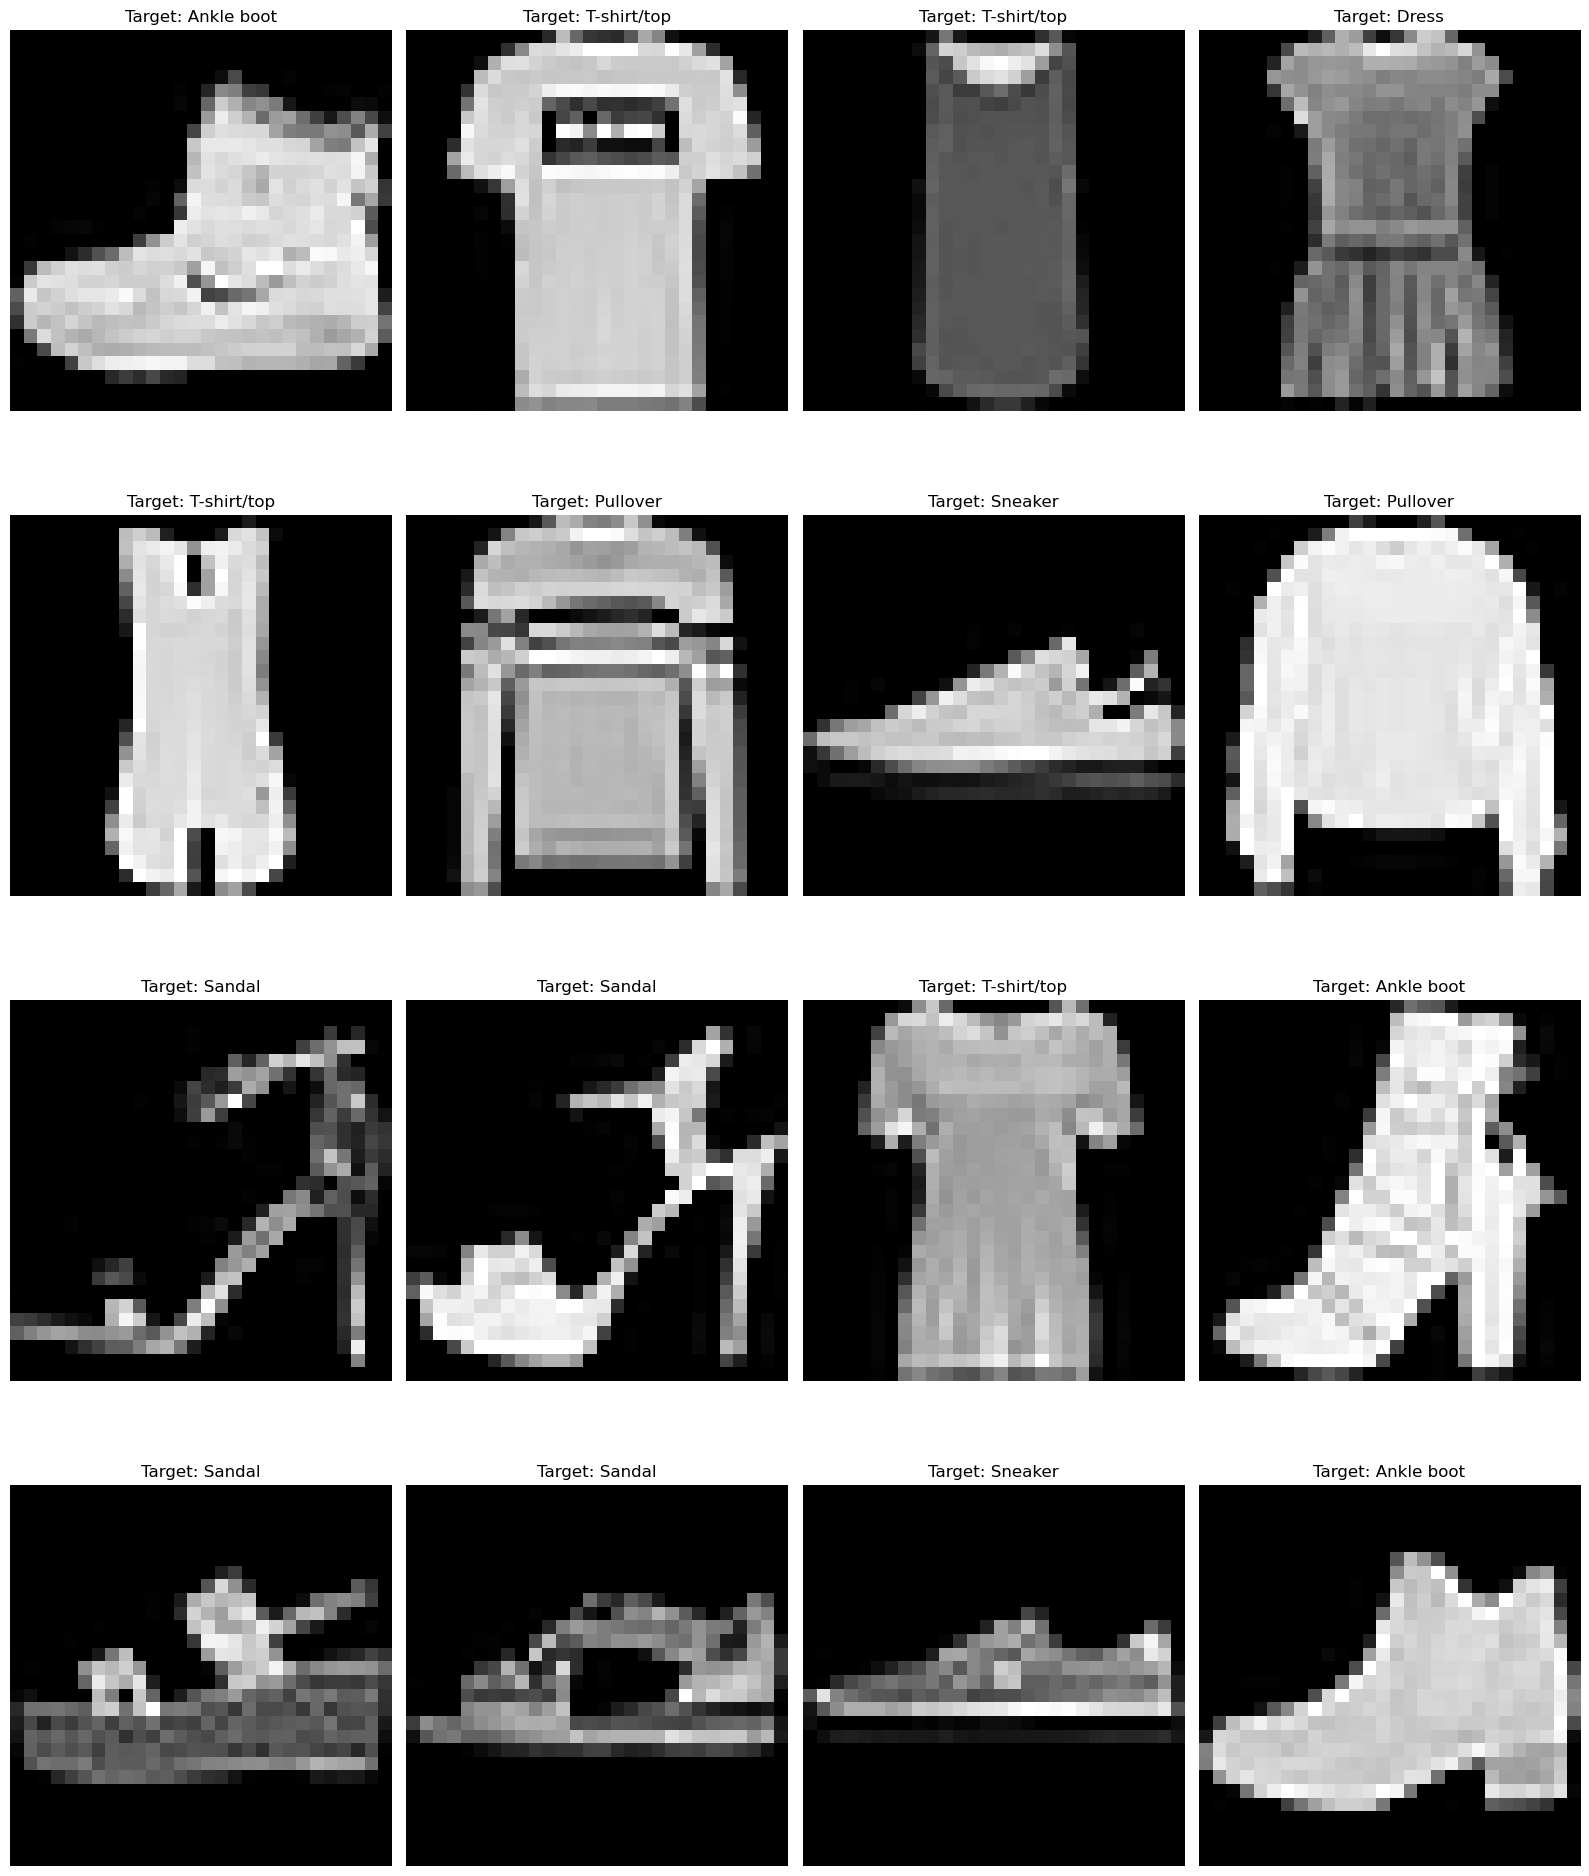

In [282]:
#Plots of the raw data, with class name labels
x_train, x_valid, x_test, y_train, y_valid, y_test = get_data()
make_graphs(x_train, y_train)

In [283]:
#Apply augmentations using keras_cv, helps to prevent overfitting.
def build_augmenter():
    augmenters = [
        keras_cv.layers.RandomShear(x_factor=0.05,y_factor=0.05),
        keras_cv.layers.RandomCutout(width_factor=(0.01, 0.05),height_factor=(1.0, 1.0)),
        keras_cv.layers.RandomCutout(width_factor=(1.0, 1.0),height_factor=(0.01, 0.05))
    ]
    
    def augment(image):
        for augmenter in augmenters:
            image = augmenter(image)
        return image
    
    return augment


In [284]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
augmenter = build_augmenter()
x_train = augmenter(x_train)

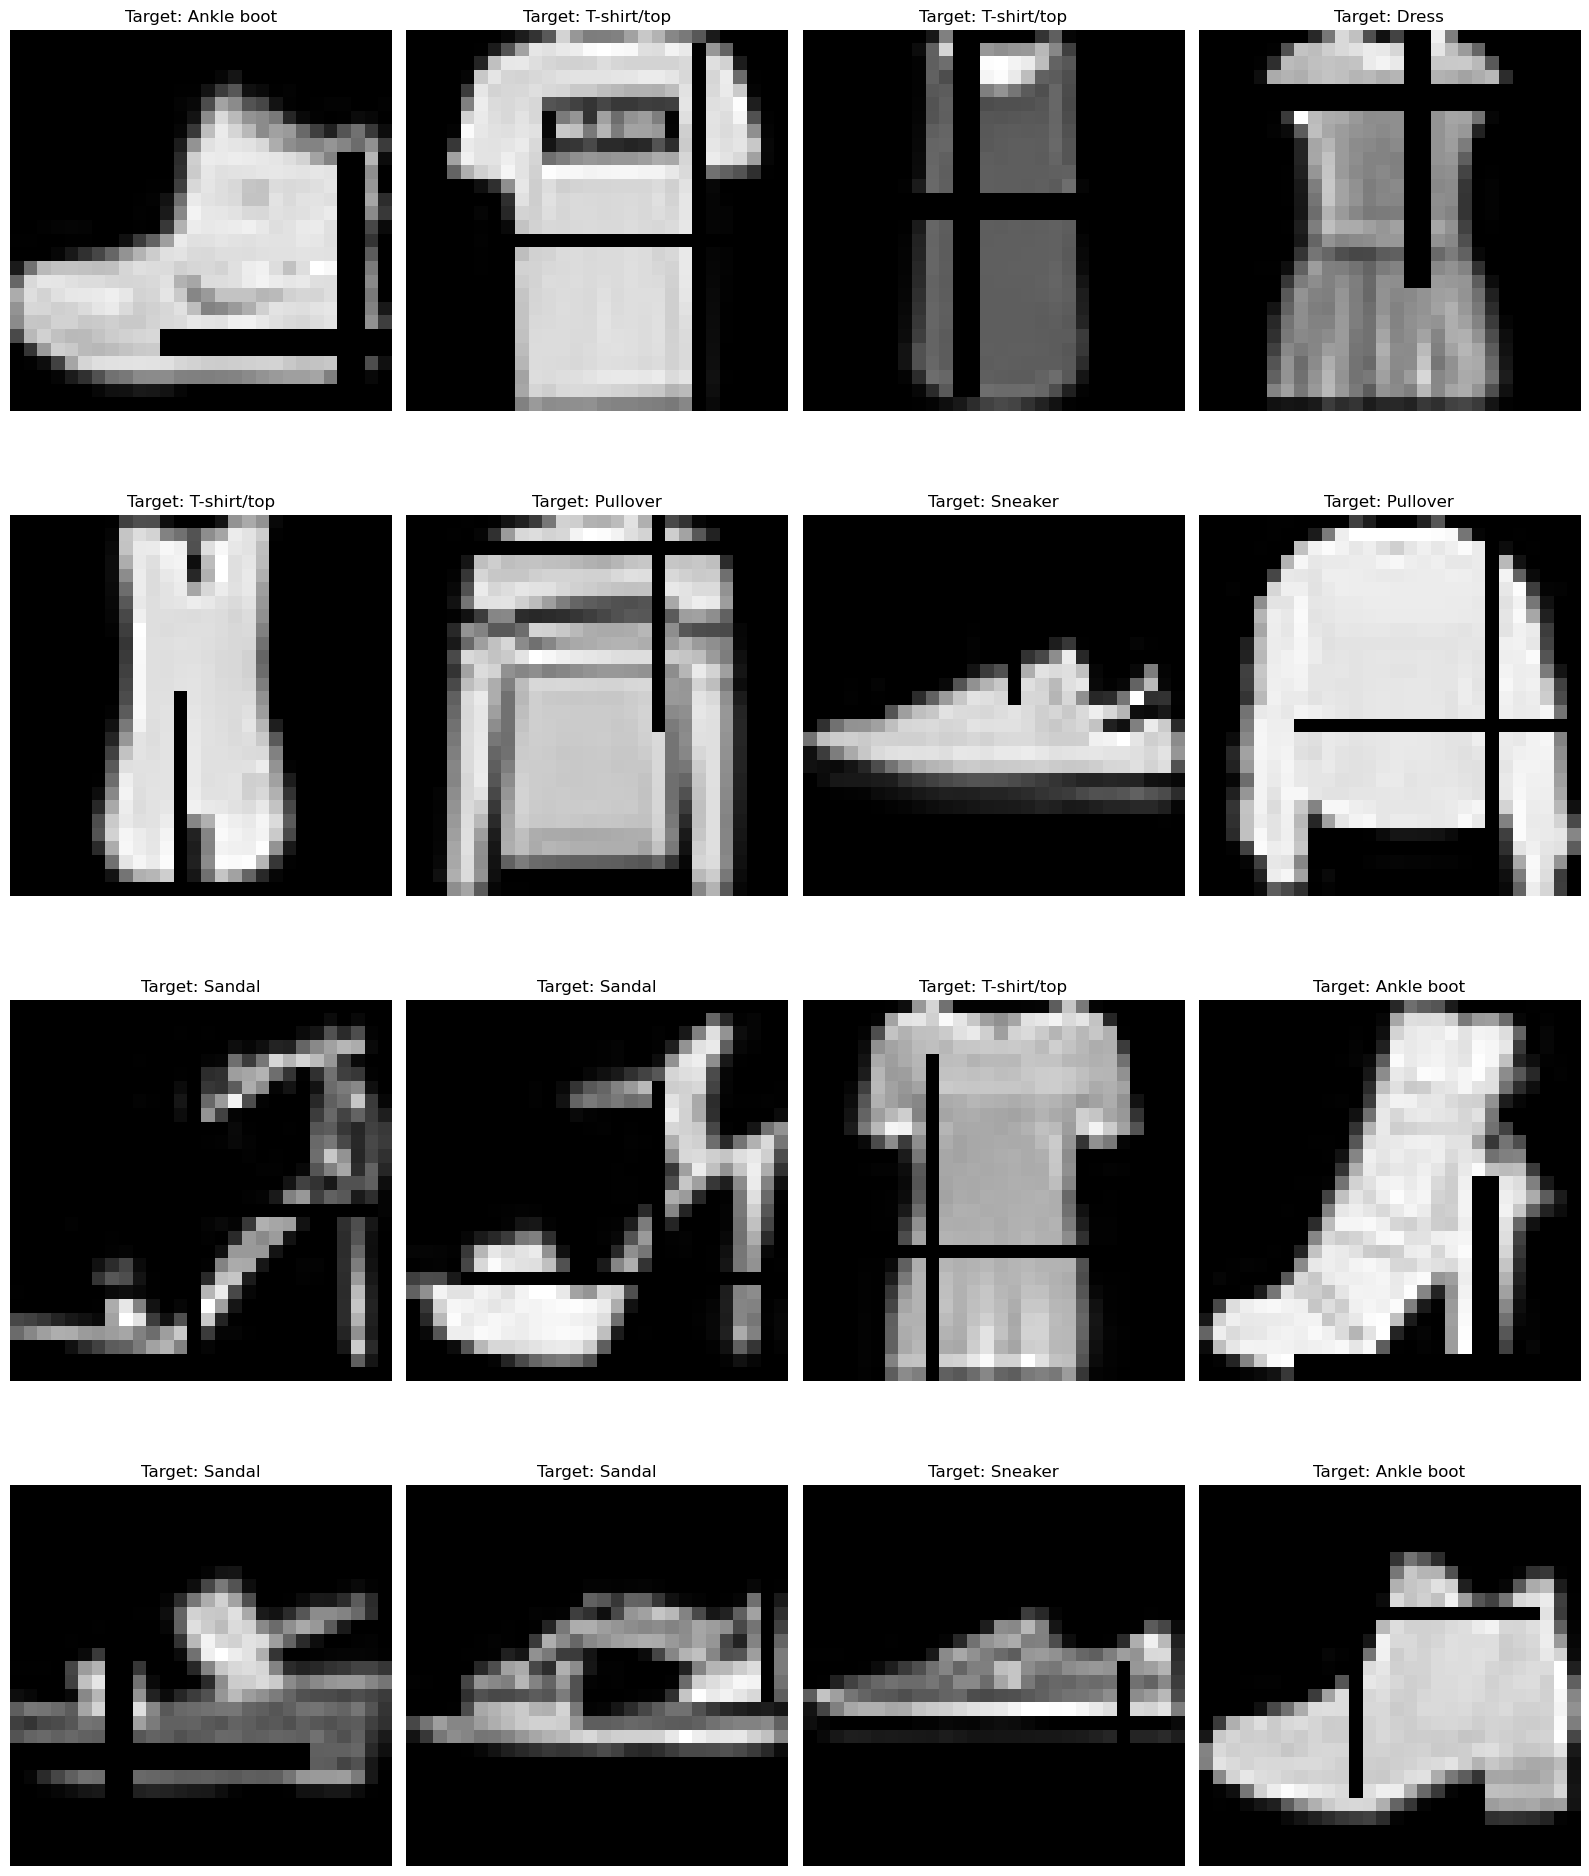

In [285]:
#Plots of the augmented data, with class name labels
make_graphs(x_train, y_train)


In [286]:
#Define model
def get_model(plot=False, summary=False, lr_scheduler="exp", initial_learning_rate=1e-3):
    model = Sequential(
        [               
            tf.keras.Input(shape=(28, 28)),
            Flatten(),
            Dense(300, activation='relu', name = "L1"),
            Dense(100, activation='relu',  name = "L2"),
            Dense(10, activation='linear', name = "L3"),
        ], name = "my_model" 
    )
    
    if lr_scheduler == "exp":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9)
    elif lr_scheduler == "cosine":
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=1000,
        alpha=0.0)
    
    #Plot of LR scheduler
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(5000), [lr_schedule.__call__(epoch) for epoch in np.arange(5000)], marker='o')
        plt.xlabel('Steps'); plt.ylabel('Learning Rate')
        plt.title('LR Scheduler')
        plt.show()

    # Compile the model  
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    # Model Sumamry
    if summary:
        model.summary()
    
    return model

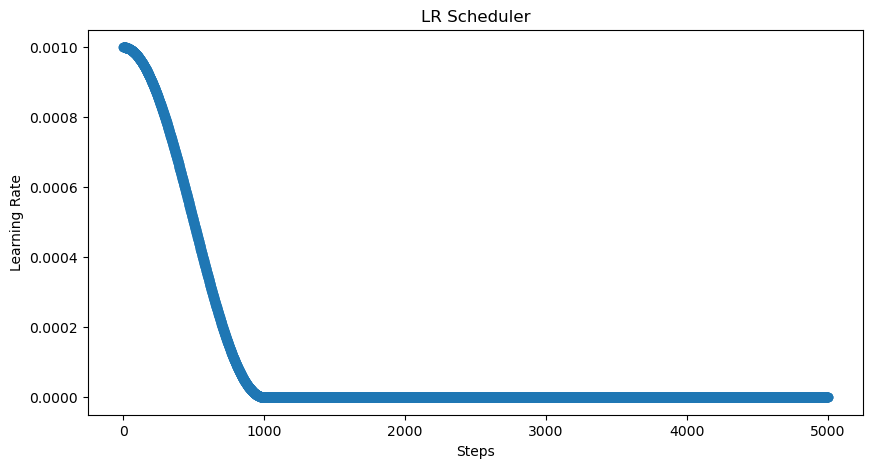

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_49 (Flatten)        (None, 784)               0         
                                                                 
 L1 (Dense)                  (None, 300)               235500    
                                                                 
 L2 (Dense)                  (None, 100)               30100     
                                                                 
 L3 (Dense)                  (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [287]:
get_model(True, True, lr_scheduler="cosine")

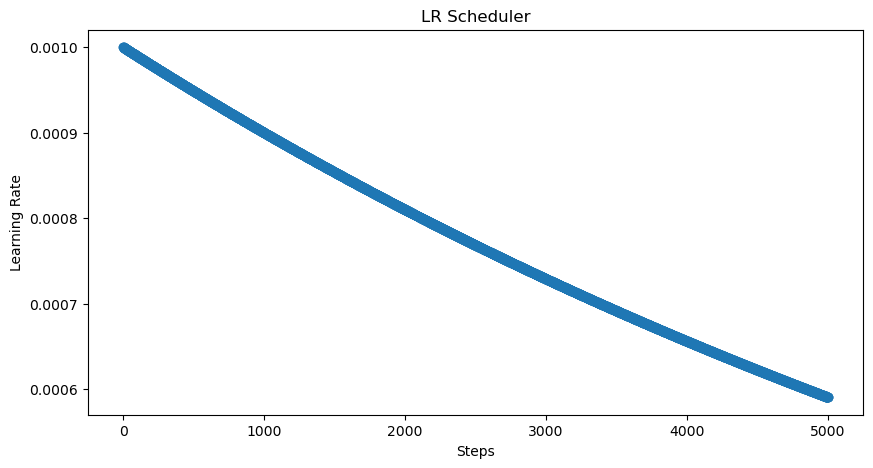

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_50 (Flatten)        (None, 784)               0         
                                                                 
 L1 (Dense)                  (None, 300)               235500    
                                                                 
 L2 (Dense)                  (None, 100)               30100     
                                                                 
 L3 (Dense)                  (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [288]:
get_model(True, True, lr_scheduler="exp")

In [289]:
def full_flow(augment=True, epochs=30, lr_scheduler="exp", initial_learning_rate=1e-3, early_stopping_patience=5):
    x_train, x_valid, x_test, y_train, y_valid, y_test = get_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    if augment:
        x_train = build_augmenter()(x_train)
    model = get_model(False, False, lr_scheduler, initial_learning_rate)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)
    history = model.fit(augmented_images, y_train, callbacks=[early_stopping_cb], epochs=epochs, validation_data=(x_valid, y_valid))
    return model, history

In [290]:
trained_model_augmented_exp, history_augmented_exp = full_flow(augment=True, lr_scheduler="exp")
trained_model_augmented_cosine, history_augmented_cosine = full_flow(augment=True, lr_scheduler="cosine")
trained_model_exp, history_exp = full_flow(augment=False, lr_scheduler="exp")
trained_model_cosine, history_cosine = full_flow(augment=False, lr_scheduler="cosine")

Epoch 1/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5659 - accuracy: 0.7926 - val_loss: 0.4044 - val_accuracy: 0.8500
Epoch 2/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4247 - accuracy: 0.8420 - val_loss: 0.3739 - val_accuracy: 0.8546
Epoch 3/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3770 - accuracy: 0.8581 - val_loss: 0.3630 - val_accuracy: 0.8706
Epoch 4/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3425 - accuracy: 0.8708 - val_loss: 0.3527 - val_accuracy: 0.8666
Epoch 5/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3158 - accuracy: 0.8797 - val_loss: 0.3336 - val_accuracy: 0.8748
Epoch 6/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2946 - accuracy: 0.8890 - val_loss: 0.3271 - val_accuracy: 0.8784
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2746 - accuracy: 0.8956 - val_loss: 0.3198 - val_accu

<Axes: title={'center': 'Cosine LR'}, xlabel='Epoch'>

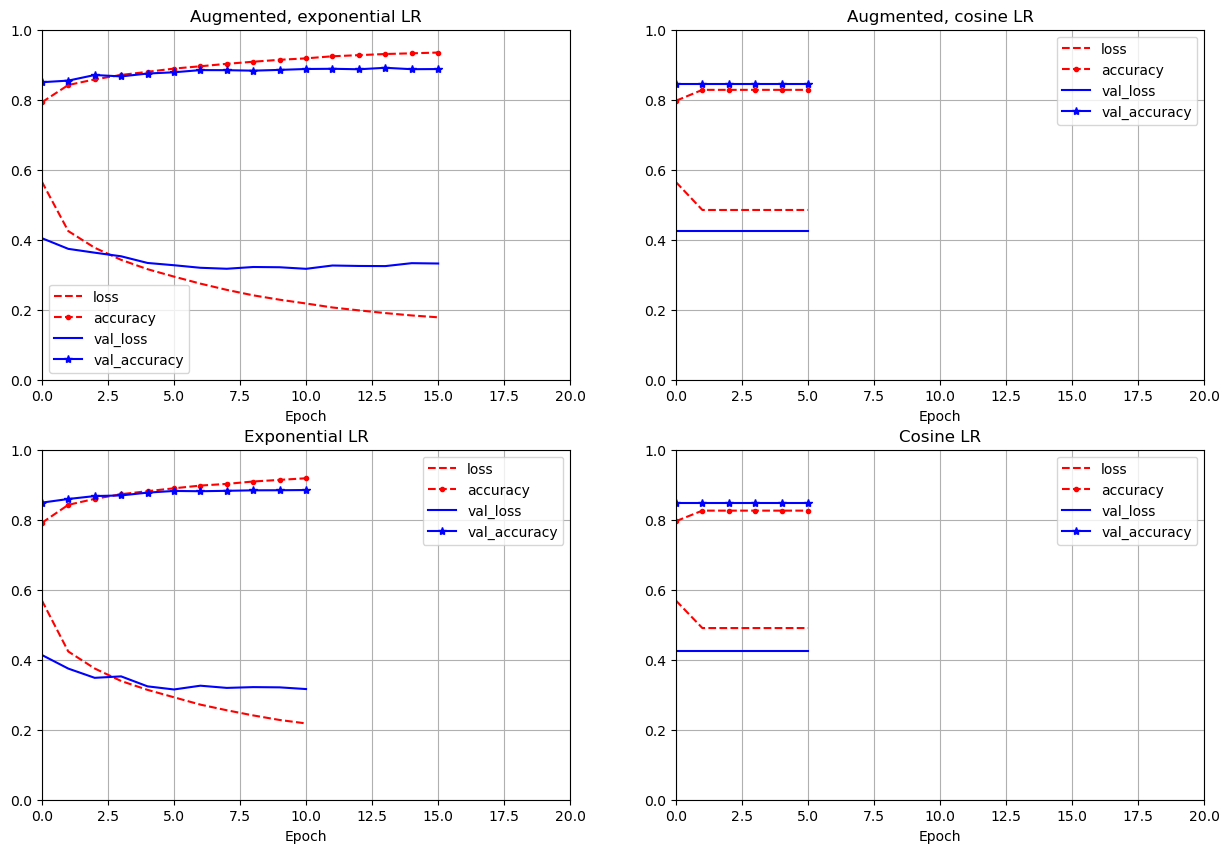

In [291]:
fig, axes = plt.subplots(nrows=2, ncols=2)

pd.DataFrame(history_augmented_exp.history).plot(title="Augmented, exponential LR", figsize=(15,10), xlim=[0,20], ylim=[0,1],grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[0,0])
pd.DataFrame(history_augmented_cosine.history).plot(title="Augmented, cosine LR", figsize=(15,10), xlim=[0,20], ylim=[0,1],grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[0,1])
pd.DataFrame(history_exp.history).plot(title="Exponential LR", figsize=(15,10), xlim=[0,20], ylim=[0,1],grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[1,0])
pd.DataFrame(history_cosine.history).plot(title="Cosine LR", figsize=(15,10), xlim=[0,20], ylim=[0,1],grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[1,1])



In [292]:
trained_model_augmented_exp.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3257 - accuracy: 0.8861


[0.32568198442459106, 0.8860999941825867]

In [293]:
x_test_pred = trained_model_augmented_exp.predict(x_test)

313/313 [==============================] - 1s 5ms/step


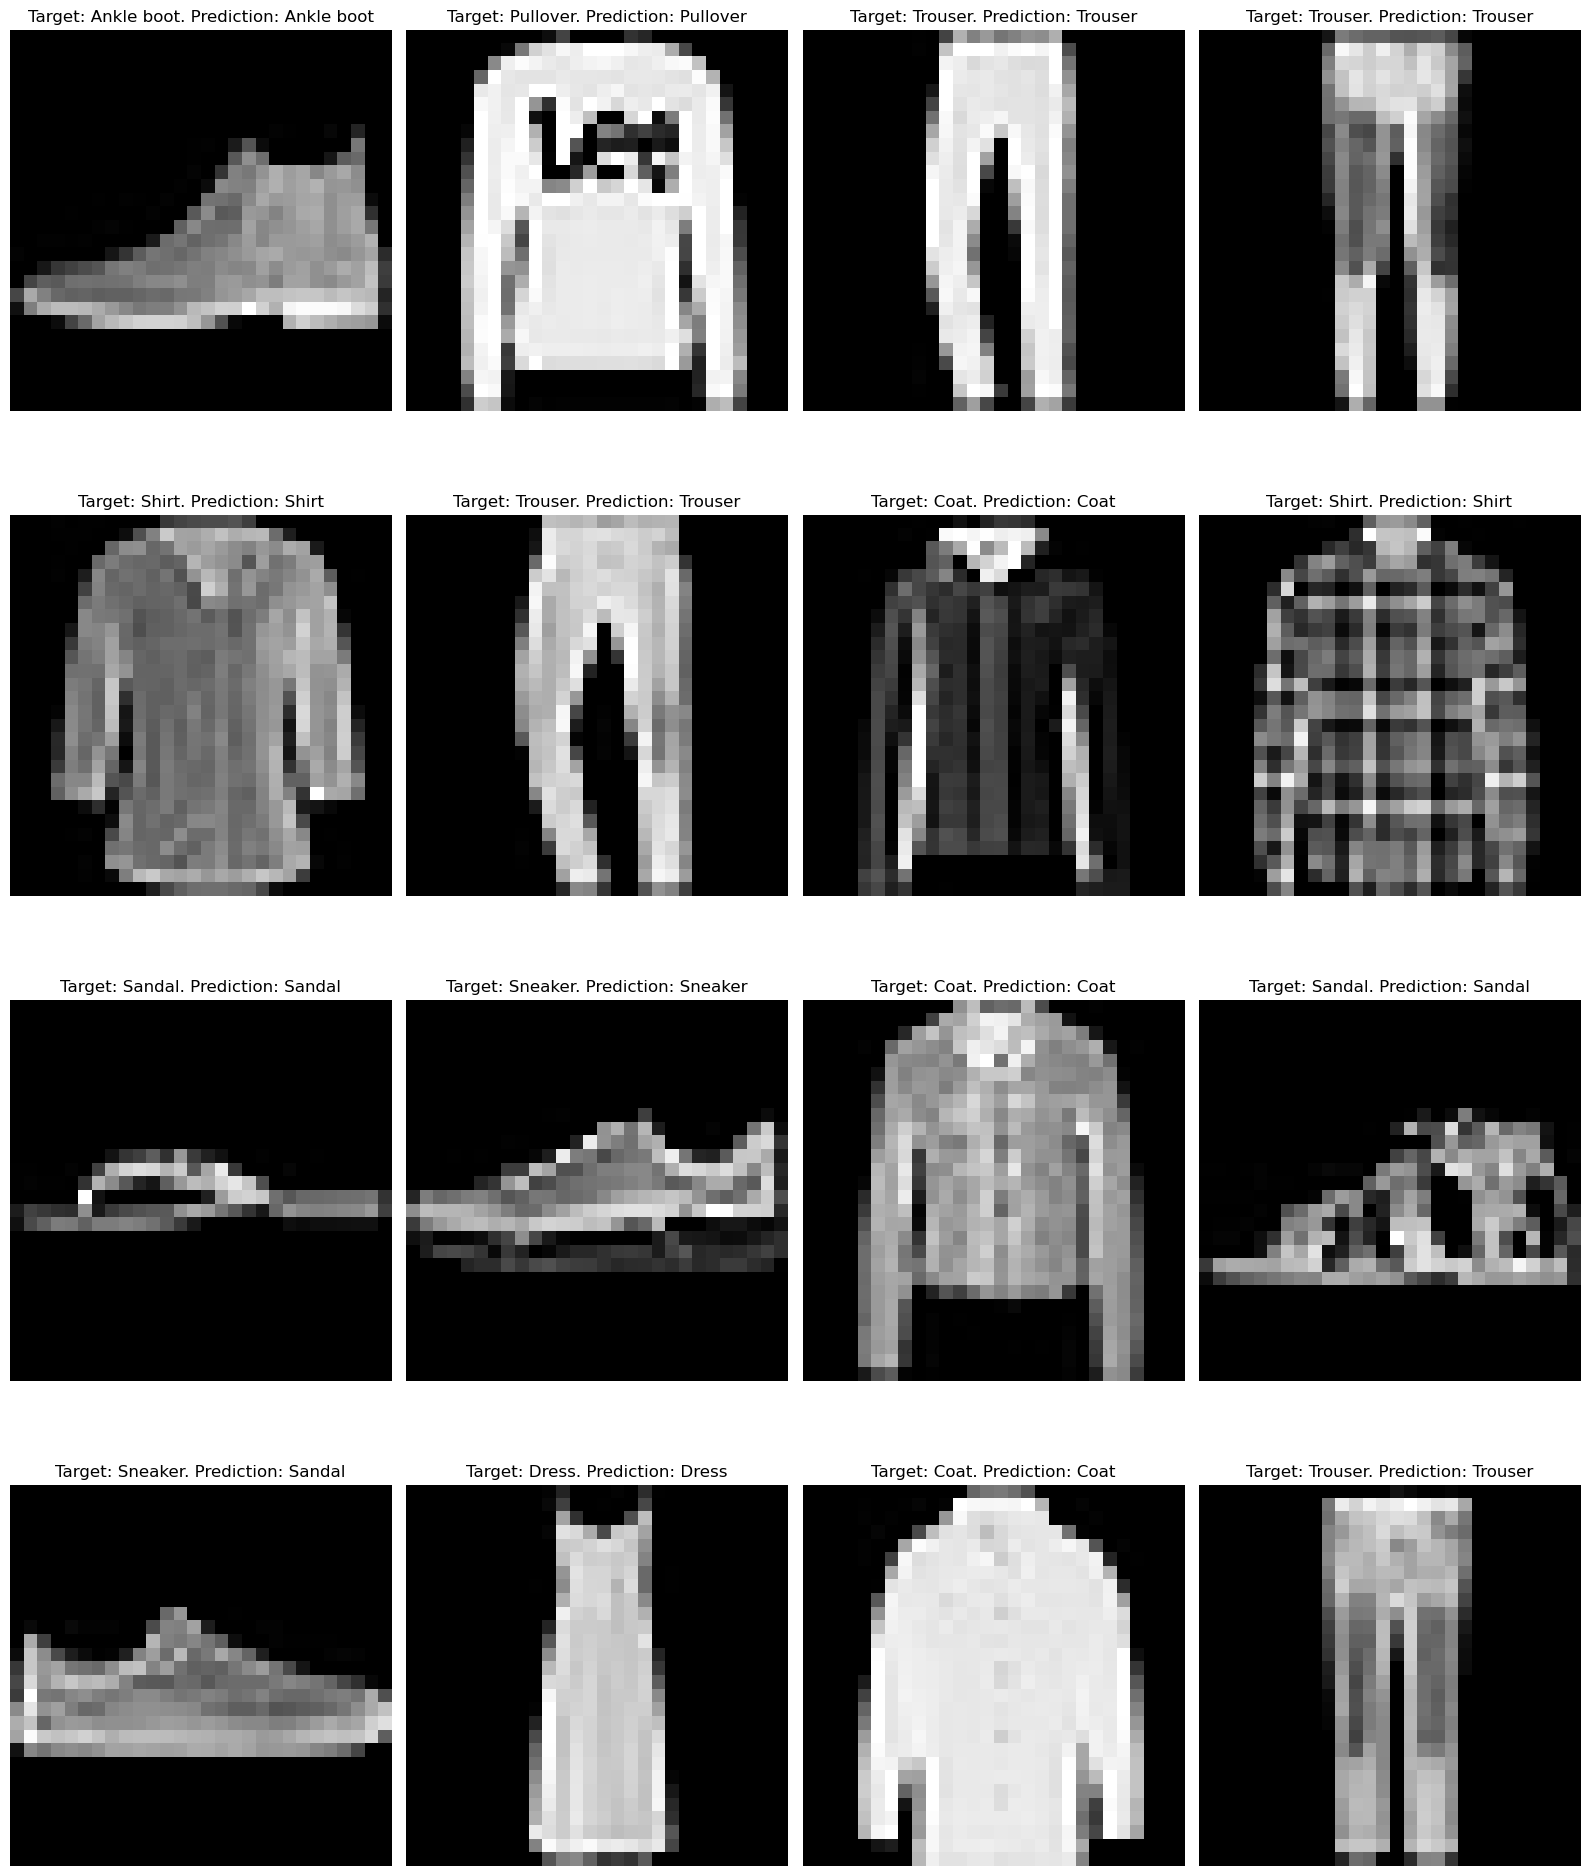

In [294]:
make_graphs(x_test, y_test, True, x_test_pred)